
# PSO Parameter Sensitivity on Ackley (Continuous)

**Parameter sensitivity analysis** for a Particle Swarm Optimizer (PSO) on the **Ackley** benchmark.

**Contents:**
- 1D sweeps (e.g., population size, inertia weight) -> line plots (mean +- std)
- 2D sweeps (e.g., phi1 × phi2 for constriction PSO) -> heatmaps
- Metrics: best objective value, hit-rate@epsilon, iterations-to-epsilon, and AUC (area under convergence curve)

In [15]:
import time
from typing import List, Tuple, Optional, Dict
import numpy as np
import matplotlib.pyplot as plt

# Project modules 
from problem.ackley import AckleyFunction
from swarm_algo.pso import ParticleSwarmOptimizer


In [16]:
# ---- Ackley from project module ----
ACKLEY_DATA_FOLDER = "../data/ackley/"

def get_ackley_problem(test_number: int) -> Tuple[int, np.ndarray, float, AckleyFunction]:
    """Load test case via project module and return (dimension, x0, initial_value, problem_obj)."""
    prob = AckleyFunction(PROBLEM_FOLDER=ACKLEY_DATA_FOLDER, PROBLEM=test_number)
    d, x0, init_val = prob.get_problem_infos()
    return d, x0, init_val, prob

def ackley_value(x: np.ndarray, problem: AckleyFunction) -> float:
    """Compute f(x) using the module's `calculate_fitness`."""
    return float(problem.calculate_fitness(np.asarray(x, dtype=float)))


In [17]:
# ---- Metrics ----
def convergence_auc(history: List[float]) -> float:
    """AUC of best-so-far curve (lower is better)"""
    y = np.asarray(history, dtype=float)
    x = np.arange(len(y))
    return float(np.trapezoid(y, x))

def iters_to_epsilon(history: List[float], eps: float) -> Optional[int]:
    """First iteration index where best-so-far <= eps. None if not reached"""
    y = np.asarray(history, dtype=float)
    idx = np.where(y <= eps)[0]
    return int(idx[0]) if idx.size > 0 else None

def summarize(values: List[float]) -> Tuple[float, float]:
    a = np.asarray(values, dtype=float)
    return float(a.mean()), float(a.std())

In [18]:
# ---- Single PSO run on Ackley ----
def run_single_pso_ackley(
    test_number: int,
    max_iters: int,
    n_particles: int,
    seed: int,
    mode: str = "constriction",
    phi1: float = 2.05, phi2: float = 2.05, chi: Optional[float] = 0.729,
    w: Tuple[float, float] = (0.9, 0.4), c1: float = 2.0, c2: float = 2.0,
    topology: str = "ring", ring_neighbors: int = 2,
    velocity_clamp: float = 0.2,
    boundary_mode: str = "clip",
    eps_target: float = 1e-3,
    early_stopping_rounds: Optional[int] = None,
    tol: float = 1e-6,
) -> Dict[str, float]:
    d, x0, init_val, prob = get_ackley_problem(test_number)
    bounds = [(-5.0, 5.0)] * d

    t0 = time.perf_counter()
    pso = ParticleSwarmOptimizer(
        objective=lambda x: ackley_value(x, prob),
        bounds=bounds,
        n_particles=n_particles,
        max_iters=max_iters,
        mode=mode,
        phi1=phi1, phi2=phi2, chi=chi,
        w=w, c1=c1, c2=c2,
        topology=topology, ring_neighbors=ring_neighbors,
        velocity_clamp=velocity_clamp,
        boundary_mode=boundary_mode,
        seed=seed,
        enable_position_history=False,
        track_positions=False,
        early_stopping_rounds=early_stopping_rounds,
        tol=tol,
        problem_type="continuous",
    )
    best_x, best_f, info = pso.optimize()
    dt = time.perf_counter() - t0

    auc = convergence_auc(info.history_best_f)
    iters_eps = iters_to_epsilon(info.history_best_f, eps_target)
    hit = 1.0 if (iters_eps is not None) else 0.0

    return dict(
        best_f=best_f,
        auc=auc,
        iters_to_eps=(iters_eps if iters_eps is not None else np.nan),
        hit=hit, time=dt, n_iter=info.n_iter
    )

In [19]:
# ---- 1D sweep ----
def sweep_1d(
    test_number: int,
    param_name: str,
    values: List,
    seeds: List[int],
    budget: Dict[str, int],
    mode_cfg: Dict = None
) -> Dict:
    if mode_cfg is None: mode_cfg = {}
    res = { "param": [], "best_f_mean": [], "best_f_std": [],
            "hit_rate": [], "iters_mean": [], "iters_std": [],
            "auc_mean": [], "auc_std": [] }

    for v in values:
        metrics = []
        for s in seeds:
            cfg = dict(
                test_number=test_number,
                seed=s,
                max_iters=budget["max_iters"],
                n_particles=budget["n_particles"],
                **mode_cfg
            )
            cfg[param_name] = v
            m = run_single_pso_ackley(**cfg)
            metrics.append(m)

        best_f = [m["best_f"] for m in metrics]
        aucs   = [m["auc"] for m in metrics]
        iters  = [m["iters_to_eps"] for m in metrics if not np.isnan(m["iters_to_eps"])]
        hits   = [m["hit"] for m in metrics]

        bf_mean, bf_std = summarize(best_f)
        auc_mean, auc_std = summarize(aucs)
        it_mean = float(np.mean(iters)) if len(iters)>0 else np.nan
        it_std  = float(np.std(iters)) if len(iters)>0 else np.nan
        hit_rate = float(np.mean(hits))

        res["param"].append(v)
        res["best_f_mean"].append(bf_mean); res["best_f_std"].append(bf_std)
        res["auc_mean"].append(auc_mean);   res["auc_std"].append(auc_std)
        res["iters_mean"].append(it_mean);  res["iters_std"].append(it_std)
        res["hit_rate"].append(hit_rate)

    return res


# ---- 2D sweep ----
def sweep_2d(
    test_number: int,
    x_name: str, x_vals: List,
    y_name: str, y_vals: List,
    seeds: List[int],
    budget: Dict[str, int],
    mode_cfg: Dict = None,
    metric: str = "best_f"  # 'best_f' | 'auc' | 'hit' | 'iters'
) -> Dict:
    if mode_cfg is None: mode_cfg = {}
    H = np.zeros((len(y_vals), len(x_vals)), dtype=float)

    for iy, yv in enumerate(y_vals):
        for ix, xv in enumerate(x_vals):
            metrics = []
            for s in seeds:
                cfg = dict(
                    test_number=test_number,
                    seed=s,
                    max_iters=budget["max_iters"],
                    n_particles=budget["n_particles"],
                    **mode_cfg
                )
                cfg[x_name] = xv
                cfg[y_name] = yv
                m = run_single_pso_ackley(**cfg)
                metrics.append(m)

            if metric == "best_f":
                vals = [m["best_f"] for m in metrics]
            elif metric == "auc":
                vals = [m["auc"] for m in metrics]
            elif metric == "hit":
                vals = [m["hit"] for m in metrics]
            elif metric == "iters":
                vals = [m["iters_to_eps"] for m in metrics if not np.isnan(m["iters_to_eps"])]
            else:
                raise ValueError("Unknown metric")

            H[iy, ix] = np.mean(vals) if len(vals)>0 else np.nan

    return {"X": x_vals, "Y": y_vals, "H": H, "metric": metric, "x_name": x_name, "y_name": y_name}

In [20]:
# ---- Plotting ----
def plot_line_with_error(x, y, yerr, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(6,4))
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    e_arr = np.asarray(yerr, dtype=float)
    ax.plot(x_arr, y_arr, marker="o")
    ax.errorbar(x_arr, y_arr, yerr=e_arr, fmt="none", alpha=0.3)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_heatmap(res2d: Dict, title: str):
    X = res2d["X"]; Y = res2d["Y"]; H = res2d["H"]
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(H, cmap="viridis", origin="upper", aspect="auto")
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(res2d["x_name"]); ax.set_ylabel(res2d["y_name"])
    ax.set_xticks(range(len(X))); ax.set_xticklabels([str(v) for v in X], rotation=0)
    ax.set_yticks(range(len(Y))); ax.set_yticklabels([str(v) for v in Y])
    plt.show()


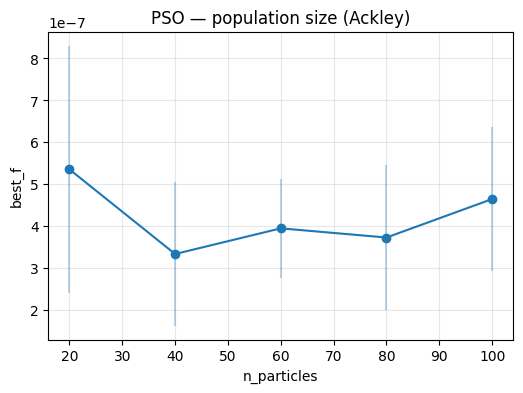

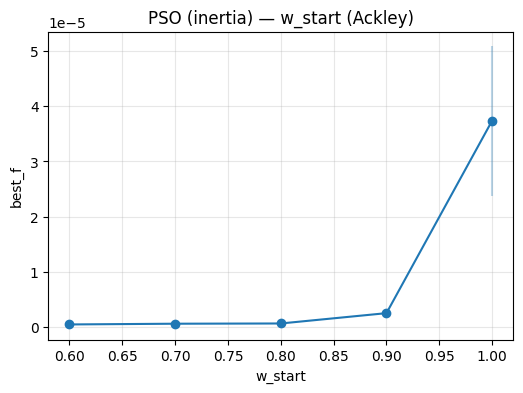

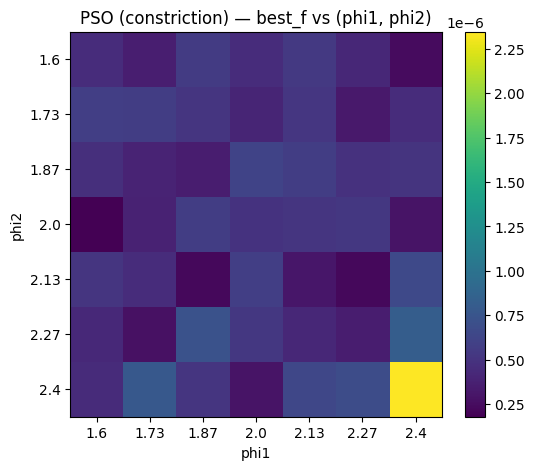

In [21]:
# ---- Config ----
TEST_NUMBER = 10      # choose a case from data/ackley/test_XX.txt
SEEDS = list(range(5))  # increase to 10/20 in real experiments
BUDGET = {"max_iters": 600, "n_particles": 50}

# ---- 1D Sweep: population size ----
pop_values = [20, 40, 60, 80, 100]
res_pop = sweep_1d(
    test_number=TEST_NUMBER,
    param_name="n_particles",
    values=pop_values,
    seeds=SEEDS,
    budget=dict(max_iters=BUDGET["max_iters"], n_particles=0),  # will be overridden
    mode_cfg=dict(mode="constriction", phi1=2.05, phi2=2.05, chi=0.729)
)
plot_line_with_error(pop_values, res_pop["best_f_mean"], res_pop["best_f_std"],
                     title="PSO — population size (Ackley)",
                     xlabel="n_particles", ylabel="best_f")

# ---- 1D Sweep: inertia weight start (mode='inertia') ----
w0_values = np.linspace(0.6, 1.0, 5).tolist()  # (w_start, w_end=0.4)
res_w0 = sweep_1d(
    test_number=TEST_NUMBER,
    param_name="w",
    values=[(w0, 0.4) for w0 in w0_values],
    seeds=SEEDS,
    budget=BUDGET,
    mode_cfg=dict(mode="inertia", c1=2.0, c2=2.0)
)
plot_line_with_error(w0_values, res_w0["best_f_mean"], res_w0["best_f_std"],
                     title="PSO (inertia) — w_start (Ackley)",
                     xlabel="w_start", ylabel="best_f")

# ---- 2D Sweep: constriction phi1 × phi2 ----
phi_grid = np.round(np.linspace(1.6, 2.4, 7), 2).tolist()
res_phi = sweep_2d(
    test_number=TEST_NUMBER,
    x_name="phi1", x_vals=phi_grid,
    y_name="phi2", y_vals=phi_grid,
    seeds=SEEDS,
    budget=BUDGET,
    mode_cfg=dict(mode="constriction", chi=0.729),
    metric="best_f"
)
plot_heatmap(res_phi, title="PSO (constriction) — best_f vs (phi1, phi2)")